In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
os.listdir()

['data_specifications',
 'stock_list.csv',
 '.DS_Store',
 'LSTM.ipynb',
 'Untitled.ipynb',
 'jpx_tokyo_market_prediction',
 'example_test_files',
 'supplemental_files',
 'train_files',
 '.ipynb_checkpoints']

In [3]:
dirc = os.getcwd()

In [4]:
train_files = dirc+'/train_files'

In [5]:
os.listdir(train_files)

['options.csv',
 'secondary_stock_prices.csv',
 'stock_prices.csv',
 'trades.csv',
 'financials.csv']

In [6]:
options = pd.read_csv(train_files+'/options.csv')
sec_stock_price = pd.read_csv(train_files+'/secondary_stock_prices.csv')
stock_price = pd.read_csv(train_files+'/stock_prices.csv')
trades = pd.read_csv(train_files+'/trades.csv')
financials = pd.read_csv(train_files+'/financials.csv')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (7,8,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (14,15,16,17,18,19,42,44) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
# Stock Price - Main source
# Secondary stock price - less liquid securities, help with assess market
sec_stock_price.shape, stock_price.shape

((2384575, 12), (2332531, 12))

In [8]:
stock_price['AdjClose'] = stock_price['Close'] * stock_price['AdjustmentFactor']

In [9]:
stock_price['Date'] = pd.to_datetime(stock_price['Date'])

In [10]:
stock_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2332531 entries, 0 to 2332530
Data columns (total 13 columns):
 #   Column            Dtype         
---  ------            -----         
 0   RowId             object        
 1   Date              datetime64[ns]
 2   SecuritiesCode    int64         
 3   Open              float64       
 4   High              float64       
 5   Low               float64       
 6   Close             float64       
 7   Volume            int64         
 8   AdjustmentFactor  float64       
 9   ExpectedDividend  float64       
 10  SupervisionFlag   bool          
 11  Target            float64       
 12  AdjClose          float64       
dtypes: bool(1), datetime64[ns](1), float64(8), int64(2), object(1)
memory usage: 215.8+ MB


In [11]:
# Use 1301 as an example
df_1301 = stock_price[stock_price['SecuritiesCode'] == 1301].set_index('Date')
df_1301.head()

,RowId,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,AdjClose
Date,,,,,,,,,,,,
2017-01-04,20170104_1301,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730,2742.0
2017-01-05,20170105_1301,1301,2743.0,2747.0,2735.0,2738.0,17900,1.0,NaN,False,0.002920,2738.0
2017-01-06,20170106_1301,1301,2734.0,2744.0,2720.0,2740.0,19900,1.0,NaN,False,-0.001092,2740.0
2017-01-10,20170110_1301,1301,2745.0,2754.0,2735.0,2748.0,24200,1.0,NaN,False,-0.005100,2748.0
2017-01-11,20170111_1301,1301,2748.0,2752.0,2737.0,2745.0,9300,1.0,NaN,False,-0.003295,2745.0


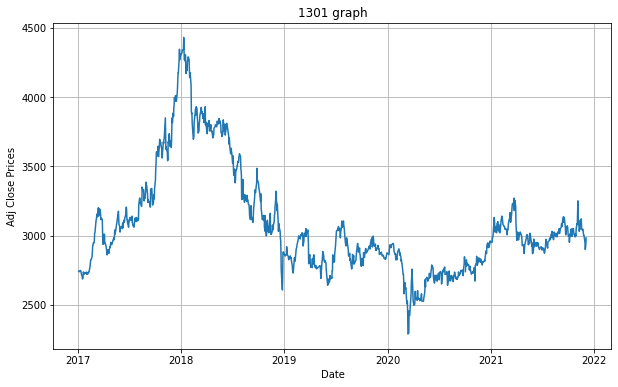

In [12]:
plt.figure(figsize = (10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Adj Close Prices')
plt.plot(df_1301['AdjClose'])
plt.title('1301 graph')
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='AdjClose', ylabel='Density'>

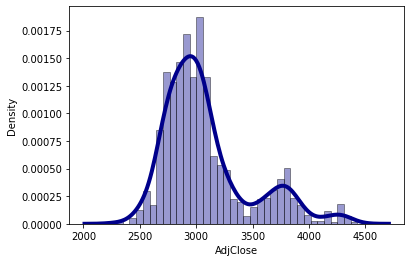

In [13]:
sns.distplot(df_1301['AdjClose'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

In [14]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
df_close = df_1301['AdjClose'].dropna()

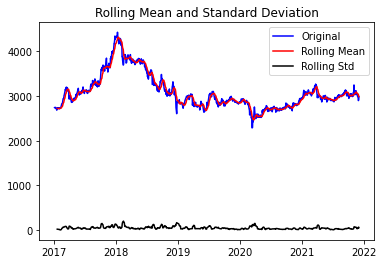

Results of Dickey-Fuller Test
Test Statistics                  -1.895782
p-value                           0.334048
No. of lags used                  0.000000
Number of observations used    1200.000000
critical value (1%)              -3.435811
critical value (5%)              -2.863952
critical value (10%)             -2.568054
dtype: float64


In [15]:
# Check stationarity
# ADF Test
# Null Hyp: The series has unit root (alpha = 1)
# Alter Hyp: The series has no unit root

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of Dickey-Fuller Test")
    adft = adfuller(timeseries,autolag='AIC')
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


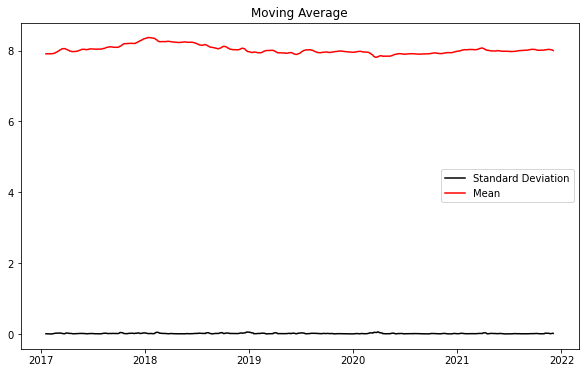

In [16]:
plt.figure(figsize=(10,6))
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

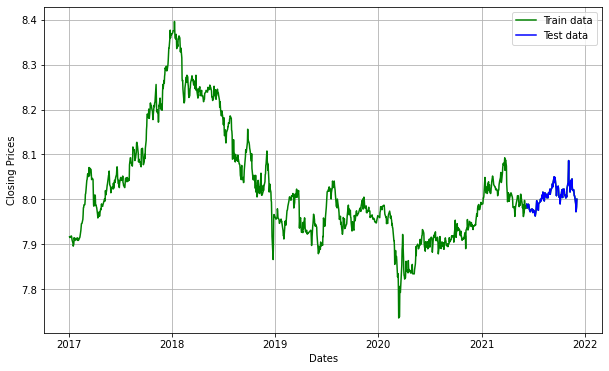

In [17]:
# Split Series into Train and Test
# Green as Train
# Blue as Test

train_data, test_data = df_log[:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()
plt.show()

In [18]:
from pmdarima import auto_arima

model = auto_arima(train_data.dropna(), start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # no periodicity
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6294.183, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6297.761, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6295.908, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6295.928, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6299.738, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.642 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1080
Model:               SARIMAX(0, 1, 0)   Log Likelihood                3150.869
Date:                Tue, 28 Jun 2022   AIC                          -6299.738
Time:                        19:08:43   BIC                          -6294.755
Sample:                             0   HQIC                         -6297.851
                               - 1080                                  

In [19]:
predict = model.predict(n_periods=df_close.shape[0])
predict

array([7.98070782, 7.98070782, 7.98070782, ..., 7.98070782, 7.98070782,
       7.98070782])

In [20]:
prediction = predict.mean()

In [21]:
T1B_return = df_log[-1]

In [22]:
return_ = prediction -T1B_return
return_

-0.019641674455014524

In [23]:
def auto_arima_model(train):
    model = auto_arima(train.dropna(), start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # no periodicity
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
    return model

In [24]:
pred_list = []
for i in stock_price['SecuritiesCode'].unique():
    df = stock_price[stock_price['SecuritiesCode']==i].set_index('Date')
    df_close = df['AdjClose'].dropna()
    df_log = np.log(df_close)
    train_data, test_data = df_log[:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
    #print(i)
    model = auto_arima_model(train_data)
    pred = model.predict(n_periods=df_close.shape[0]).mean()
    
    T1B_return = df_log[-1]
    return_ = prediction -T1B_return
    pred_list.append([i,return_])

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6294.183, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6297.761, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6295.908, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6295.928, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6299.738, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.614 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5513.246, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5515.860, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5515.244, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5515.252, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5517.859, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.432 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5764

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5158.097, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5161.991, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5160.039, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5160.034, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5163.973, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.599 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5364.121, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5368.088, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5366.121, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5366.121, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5369.865, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.575 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5242.340, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5800.187, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5802.134, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5802.226, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5802.154, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5804.011, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.660 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5640.682, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5635.255, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5638.798, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5638.264, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5637.181, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5637.537, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5636.987, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-5638.982, Time=0.29 sec
 ARIMA(2,

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4675.151, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4679.112, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4677.241, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4677.234, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4680.698, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.473 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2618.074, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2621.843, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2620.000, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2620.003, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2622.994, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.452 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5683.857, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5330.078, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5326.179, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5326.774, Time=0.37 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5326.511, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5327.876, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5325.887, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5325.574, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-5327.305, Time=0.27 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5327.824, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-5327.474, Time=1.47 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-5331.896, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-5328.235, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5328.502, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-5327.636, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-5327.218, Time=0.32

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5629.034, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5628.845, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5631.226, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.091 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5702.107, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5706.527, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5704.893, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5704.917, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5707.995, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.454 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6159.388, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6158.133, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6156.848, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0]

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-5337.393, Time=0.74 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-5343.048, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-5329.527, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5328.517, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-5341.086, Time=0.39 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-5339.649, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-5334.452, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-5332.240, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-5339.388, Time=0.29 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 3.736 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3266.266, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3269.966, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3268.231, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3268.229, Time=0.07 sec
 ARIMA(0,

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5884.639, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5888.065, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5886.461, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5886.458, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5889.902, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.653 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3922.179, Time=0.72 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3918.367, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3916.392, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3916.396, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3920.343, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-3921.716, Time=0.63 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3921.769, Time=0.55 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3920.789, Time=0.39 sec
 ARIMA(2,

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5834.300, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.812 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6064.530, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6054.862, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6065.298, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6066.321, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6055.393, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-6065.249, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-6065.999, Time=0.34 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-6066.409, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-6064.509, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-6065.220, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-6065.463, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-6065.314, Time=0.06 sec

Best mod

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-4052.128, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 2.017 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4153.443, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4156.936, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4155.483, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4155.490, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4158.035, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.756 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3452.009, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3456.009, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3454.009, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3454.009, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3455.711, Time=0.04 sec

Best model:  ARIMA(0,1

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3669.054, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3672.075, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.511 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4913.622, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4914.643, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4915.341, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4915.293, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4913.755, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4913.438, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4911.420, Time=0.35 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4914.157, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.303 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-5717.011, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5461.363, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5464.973, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.778 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2632.881, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2636.845, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2634.865, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2634.866, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2637.826, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.605 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-5928.387, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=7699.366, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0]             

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-5561.680, Time=0.13 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 4.697 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-7850.329, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=7537.722, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.46 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-7462.512, Time=0.44 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-7845.346, Time=0.55 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-7883.434, Time=0.25 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-6145.772, Time=0.29 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-7876.546, Time=0.25 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AI

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5867.919, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5865.044, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5869.824, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5869.393, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5867.043, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5868.534, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5866.701, Time=0.52 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5871.823, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-5870.533, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-5869.891, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-5871.363, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-5875.091, Time=0.30 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-5872.355, Time=0.21 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-5870.803, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-5083.815, Time=0.30 sec

Best model:  ARIMA(1,0,3)(0,0,0)[0] intercept
Total fit time: 6.217 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-4981.177, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=7476.928, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-4957.116, Time=0.28 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-4981.095, Time=0.34 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.70 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-4987.989, Time=0.20 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-1390.039, Time=0.23 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-497

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4538.526, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4541.903, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4540.989, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4540.961, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4543.843, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.498 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5358.426, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5346.932, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5359.264, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5358.399, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5348.890, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5358.248, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5356.123, Time=0.80 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5361.234, Time=0.06 sec
 ARIMA(2,

 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4066.009, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4067.190, Time=0.78 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-4067.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-4065.393, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-4065.991, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4066.929, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-4066.584, Time=0.33 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 2.644 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2974.486, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2977.284, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2976.385, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2976.402, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2979.240, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.466 seconds

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3374.443, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3378.034, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3376.200, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3376.203, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3378.773, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.756 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5283.691, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5287.003, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5285.539, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5285.512, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5288.200, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.652 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-5978.720, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4845.134, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4843.148, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4843.147, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4846.364, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.561 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5991.172, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5987.820, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5990.896, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5991.251, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5988.865, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-5990.429, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5988.401, Time=0.63 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-5992.129, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-5991.817, Time=0.06 sec
 ARIMA(0,

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5985.612, Time=0.62 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5991.455, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-5989.456, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-5989.457, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-5991.191, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-5987.463, Time=0.14 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.810 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-5909.904, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6231.573, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-5910.809, Time=0.24 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-5894.711, Time=0.29 sec
 ARIMA(2,0,2)(0,0,0)[0]     

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5747.377, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5744.141, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-5745.378, Time=0.45 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5743.393, Time=0.37 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-5749.344, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-5747.345, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-5747.345, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5749.308, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-5745.312, Time=0.13 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.652 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5459.117, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5460.063, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5459.671, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5459.855, Time=0.41 sec
 ARIMA(0,

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5831.734, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5835.199, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5833.217, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5833.214, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5837.104, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.912 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4717.539, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4720.227, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4719.473, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4719.467, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4722.213, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.714 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4465.898, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]

 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5956.085, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5954.071, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5960.010, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-5958.085, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-5958.051, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-5959.899, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-5956.095, Time=0.17 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.555 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5395.583, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5399.583, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5397.652, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5397.652, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5401.464, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.594 seconds

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6066.729, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6066.794, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6070.039, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.865 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5764.017, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5768.017, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5766.021, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5766.003, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5770.016, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.808 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6505.377, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6509.238, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6507.679, Time=0.32 sec
 ARIMA(0,1,1)(0,0,0)[0]

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5557.105, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5556.211, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5554.460, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5554.481, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5558.061, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.070 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4163.673, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4163.475, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4164.257, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4164.676, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4163.142, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4166.380, Time=0.45 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4166.579, Time=0.62 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4177.871, Time=1.06 sec
 ARIMA(2,

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4559.668, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4563.302, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4561.629, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4561.631, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4565.288, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.427 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5561.596, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5563.749, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5563.334, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5563.244, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5565.667, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.269 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4524.240, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4161.290, Time=0.67 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-4165.947, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-4163.947, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-4163.932, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4165.881, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-4163.039, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.645 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4075.049, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4077.163, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4076.918, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4076.977, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4078.791, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.644 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0]

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4470.844, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4473.497, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4472.711, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4472.671, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4475.442, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.809 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5620.886, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5617.734, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5622.894, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5622.402, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5618.193, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5621.730, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5625.665, Time=0.70 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-5624.664, Time=0.18 sec
 ARIMA(2,

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5739.907, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5743.006, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.566 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5254.047, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5258.038, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5256.047, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5256.046, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5259.981, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.921 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5337.861, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5341.583, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5339.854, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5339.864, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5262.677, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.630 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5613.542, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5612.474, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5614.907, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5615.283, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5614.224, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-5614.783, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5614.944, Time=0.42 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-5617.064, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-5615.296, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-5616.539, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5616.687, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-5616.463, Time=0.09 sec

Best mod

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4325.063, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4306.988, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4324.454, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4321.805, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4308.976, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4330.490, Time=0.38 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4326.927, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-4326.617, Time=0.28 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4328.714, Time=0.79 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4330.377, Time=0.81 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-4328.180, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-4328.272, Time=1.10 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-4332.593, Time=0.36 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-4327.057, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-6152.042, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=7340.213, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.65 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-6150.260, Time=0.39 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-6178.522, Time=0.21 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-4343.272, Time=0.48 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-6171.402, Time=0.21 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-6175.418, Time=0.30 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-6176.524, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-3194.902, Tim

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2829.673, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2830.323, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2831.680, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2831.669, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2831.459, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2829.684, Time=0.34 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2827.677, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2832.864, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-2830.870, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2830.857, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-2832.851, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-2828.861, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 2.363 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6266.017, Time=0.31 sec
 ARIMA(0,

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5342.933, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5334.505, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-5341.094, Time=0.34 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5339.095, Time=0.44 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-5344.905, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-5343.105, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-5343.058, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5344.494, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-5341.067, Time=0.20 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 2.006 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5232.457, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5236.267, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5234.297, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5234.298, Time=0.11 sec
 ARIMA(0,

 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-3707.625, Time=0.15 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-3706.758, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=4385.723, Time=0.15 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.63 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-3725.377, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-1448.969, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-3723.200, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-3723.255, Time=0.32 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-3723.553, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-216.360, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-2174.606, Time=0.31 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-3725.330, Time=0.10 sec
 ARIMA(2,0,2)(0,0,0)[

 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-3786.820, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-3787.044, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-3785.086, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-3809.478, Time=0.17 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-1725.660, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-3810.107, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-542.531, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-3809.597, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-3806.480, Time=1.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 2.439 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept 

 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-4465.180, Time=0.52 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=3306.241, Time=0.25 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.57 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-4471.080, Time=0.21 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-1849.216, Time=0.35 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-4470.256, Time=0.18 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-4469.369, Time=0.30 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-4470.366, Time=0.37 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-863.067, Time=0.38 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-2454.716, Time=0.63 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-4467.328, Time=1.06 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-4468.366, Time=0.46 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0] intercept
Total fit time: 7.532 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6381.440, Time=0.29 sec
 ARIMA(0,1,0)(0,0

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4038.807, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4040.125, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4039.541, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4039.424, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4042.123, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.686 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3505.286, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3508.432, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3506.467, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3506.465, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3510.282, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.718 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3542.498, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]

 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-3633.497, Time=0.54 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-3631.500, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-3636.183, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-3634.807, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-3634.765, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-3635.981, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-3632.810, Time=0.04 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.837 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4170.110, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4173.925, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4172.119, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4172.103, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4175.848, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.610 seconds

 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-5651.797, Time=0.51 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-5654.106, Time=0.80 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-5660.605, Time=0.46 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-5661.817, Time=0.20 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-5660.982, Time=0.87 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-5664.278, Time=0.48 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-5653.235, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-5659.531, Time=0.39 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-5659.066, Time=0.45 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-5661.990, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-5654.756, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-5663.250, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-5664.809, Time=0.45 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-5653.732, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-5660.951, Time=0.21

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5182.838, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5183.863, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.719 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2999.307, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3003.246, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3001.297, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3001.297, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3004.313, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.518 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4580.786, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4582.321, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4582.555, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4582.591, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]

 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4078.510, Time=0.70 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4076.840, Time=0.94 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-4080.752, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-4080.532, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-4080.493, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4080.403, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-4078.823, Time=0.32 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.214 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3172.697, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3176.426, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3174.700, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3174.694, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3178.235, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.521 seconds

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5636.029, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5637.933, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.792 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3218.358, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3222.267, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3220.356, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3220.359, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3223.756, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.547 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3292.291, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3295.606, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3293.927, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3293.952, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-5263.957, Time=0.19 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 3.111 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5584.840, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5588.833, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5586.840, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5586.841, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5590.680, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.963 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2594.438, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2598.398, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2596.433, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2596.433, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2599.538, Time=0.05 sec

Best model:  ARIMA(0,1

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4928.028, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4931.920, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4930.031, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4930.024, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4933.862, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.534 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4538.350, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4542.217, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4540.345, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4540.353, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4542.876, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.800 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4279.742, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4904.070, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4906.683, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4905.232, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4905.276, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4908.631, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.875 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4418.607, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4421.555, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4420.602, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4420.634, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4423.172, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.594 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5177.253, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]

 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-2198.360, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-5146.187, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-5163.667, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-5163.186, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-924.611, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-2991.927, Time=0.54 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-5162.710, Time=1.19 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 5.496 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-4312.346, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6044.423, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-4302.240, Time=0.29 sec
 ARIMA(1,0,2)(0,0,0)[0]      

 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-5752.247, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5750.652, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-5754.064, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-5752.930, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-5754.001, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5753.707, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-5752.394, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.585 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5833.977, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5835.985, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5835.376, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5835.352, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5837.904, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.658 seconds

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5764.158, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5768.158, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5766.246, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5766.240, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5770.122, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.795 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5562.344, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5550.323, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5560.741, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5562.580, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5551.308, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-5563.974, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5576.549, Time=0.40 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5818.256, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5822.076, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.792 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3409.181, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3405.780, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3408.986, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3408.222, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3407.092, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-3409.870, Time=0.54 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-3413.867, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-3418.141, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-3416.177, Time=0.52 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-3419.546, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-3415.359, Time=0.08 sec
 ARIMA(3,

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3814.294, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3820.510, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3820.698, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3815.472, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3818.726, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3816.796, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-3822.007, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-3820.015, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-3820.018, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-3821.828, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-3818.120, Time=0.16 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.312 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4280.854, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4284.836, Time=0.06 sec
 ARIMA(1,

 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-5299.766, Time=0.84 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-5396.383, Time=0.69 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-5395.304, Time=0.19 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-5394.744, Time=0.18 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-5392.557, Time=0.58 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-5393.572, Time=0.28 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-5391.913, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-5397.040, Time=0.25 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-3583.608, Time=0.63 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-5396.084, Time=0.31 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-2741.119, Time=0.18 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-4005.364, Time=0.63 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-5394.916, Time=0.46 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0] intercept
Total fit time: 6.732

 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-4522.081, Time=1.48 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-4520.234, Time=0.62 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-4522.500, Time=1.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-1546.137, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-4521.222, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-270.896, Time=0.21 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-2444.096, Time=0.38 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 12.349 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5923.398, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5929.193, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5928.321, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5928.383, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5927.838, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.820 seconds

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4461.932, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4462.023, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4464.787, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.686 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4971.627, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4973.236, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4973.614, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4973.625, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4975.209, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.549 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5468.749, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5465.397, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5465.629, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4973.483, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4973.488, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4975.493, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.730 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-5283.640, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=7298.646, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.56 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-5280.948, Time=0.38 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.41 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=1.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-5293.029, Time=0.20 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-212

 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-5501.837, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-5501.833, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-5499.584, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-5499.832, Time=0.16 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 2.843 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4457.136, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4456.210, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4458.482, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4458.786, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4457.809, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4457.624, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4455.045, Time=0.50 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-4460.433, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-4458.775, Time=0.08 sec
 ARIMA(0,

 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.45 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-5417.726, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-5416.252, Time=0.22 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-5430.329, Time=0.35 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-1397.085, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-5428.326, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-32.130, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-2448.003, Time=0.32 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-5426.113, Time=0.41 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 3.393 seconds
Performing stepwise sea

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6062.673, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6057.671, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-6060.880, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-6058.687, Time=0.34 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-6063.930, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-6062.209, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-6062.113, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-6063.684, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-6059.930, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.658 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-4621.571, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=7125.868, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4419.149, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4422.640, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.477 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5160.225, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5163.669, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5162.262, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5162.275, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5165.027, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.553 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5646.783, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5647.225, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5647.193, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5647.372, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4615.854, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4618.266, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.732 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6210.355, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6214.356, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6212.366, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6212.350, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6216.255, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.639 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5135.528, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5138.216, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5137.612, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5137.574, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5236.801, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5235.120, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5235.115, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5238.733, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.645 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5571.532, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5574.592, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5573.017, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5573.005, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5576.576, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.653 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4687.618, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4691.386, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5136.503, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5138.453, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.680 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4348.071, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4351.680, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4350.028, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4350.060, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4353.421, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.488 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5202.256, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5204.443, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5204.143, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5204.133, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2515.961, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2519.772, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2517.890, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2517.893, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2520.349, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.618 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2466.787, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2470.245, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2468.695, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2468.688, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2470.565, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.735 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4822.314, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0]

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5204.885, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5207.034, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.448 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-4503.938, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=7426.692, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-4502.229, Time=0.37 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.41 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-4509.699, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-904.321, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, 

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2565.967, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2569.923, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2567.966, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2567.967, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2570.951, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.634 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2509.537, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2511.833, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2510.640, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2510.608, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2512.841, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.622 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3199

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3263.577, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3267.517, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3265.619, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3265.620, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3268.725, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.464 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2577.261, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2581.206, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2579.261, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2579.261, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2582.669, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.513 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4632.114, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3186.968, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3185.010, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3185.011, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3188.488, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.334 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4609.530, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4613.417, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4611.532, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4611.528, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4615.411, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.384 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5236.200, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5238.402, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5355.026, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.706 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5143.583, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5145.760, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5145.495, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5145.685, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5147.501, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.905 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-5659.950, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=7494.905, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-5658.002, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5250.318, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5250.328, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5253.876, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.923 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-3903.546, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=7492.094, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.46 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-3901.390, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-3915.624, Time=0.37 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=1.13 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-391

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4504.429, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4507.815, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.599 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3713.325, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3716.913, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3715.165, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3715.185, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3718.861, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.479 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4154.004, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4157.681, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4156.000, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4156.008, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3487.545, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3487.597, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3487.635, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3487.535, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3485.696, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3484.046, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-3487.790, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-3485.807, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-3485.823, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-3487.757, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-3484.574, Time=0.23 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.594 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3850.032, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3853.964, Time=0.07 sec
 ARIMA(1,

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5506.250, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5506.655, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.620 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4558.003, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4560.924, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4560.002, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4560.003, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4562.172, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.441 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4944.105, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4948.103, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4946.105, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4946.104, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]

 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-4005.320, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-4001.329, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.975 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3719.665, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3722.788, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3721.650, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3721.631, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3724.785, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.444 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-3178.836, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=7245.538, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0]             

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4311.853, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4314.965, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.718 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5444.444, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5441.929, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5445.682, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5445.570, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5443.905, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5443.832, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5441.781, Time=0.39 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5447.654, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-5445.804, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-5446.417, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-5447.542, Time=0.13 sec
 ARIMA(2,

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3567.668, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3571.660, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3569.668, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3569.667, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3572.851, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.513 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5493.414, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5494.526, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5495.321, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5495.525, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5496.244, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.842 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4419.910, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5305.849, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5311.766, Time=0.29 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5312.351, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5302.657, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-5311.255, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5309.731, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-5308.056, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 1.259 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3112.588, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3116.462, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3114.518, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3114.520, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3118.250, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.749 seconds

 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-5352.242, Time=0.32 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-5365.624, Time=0.39 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.39 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-5355.654, Time=0.51 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-5381.337, Time=0.73 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-3045.131, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-5381.209, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-5258.089, Time=0.44 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-5379.397, Time=0.83 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-1858.639, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-3852.664, Time=0.27 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-5379.571, Time=0.34 sec
 ARIMA(2,0,2)(0,0,0

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5246.771, Time=0.34 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5252.630, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-5250.859, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-5252.264, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-5252.499, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-5250.377, Time=0.26 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.605 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5167.594, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5171.563, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5169.593, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5169.593, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5173.099, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.729 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0]

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5375.926, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5379.498, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.893 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4629.516, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4629.058, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4631.169, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4631.375, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4630.968, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4629.779, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4628.203, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-4633.282, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-4631.421, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-4631.686, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4633.092, Time=0.06 sec
 ARIMA(1,

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5179.922, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5178.632, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5176.775, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5176.754, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5179.397, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5181.907, Time=0.46 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5177.946, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-5180.940, Time=0.86 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-5180.178, Time=0.35 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5182.780, Time=0.46 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-5177.662, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-5180.988, Time=0.31 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-5177.726, Time=0.34 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-5178.942, Time=0.54 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-5183.675, Time=0.20

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5010.015, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5008.857, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5008.113, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5006.121, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5011.979, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-5009.997, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-5009.990, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-5011.896, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-5008.005, Time=0.17 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.205 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4331.208, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4329.225, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4328.949, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4328.877, Time=0.07 sec
 ARIMA(0,

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3184.710, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3188.697, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3186.711, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3186.710, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3189.212, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.482 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5333.333, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5331.981, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5334.698, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5334.973, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5333.869, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-5333.632, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5334.638, Time=0.52 sec
 ARIMA(0,1,1)(0,0,0)[0]          

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4244.819, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4246.830, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4246.763, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4242.795, Time=0.37 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-4253.980, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-4249.819, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4249.771, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-4252.061, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-4252.062, Time=0.33 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-4248.388, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-4248.322, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-4244.353, Time=0.10 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 3.243 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3236.122, Time=0.23 sec
 ARIMA(0,

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5224.849, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5220.443, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5226.676, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5226.418, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5222.419, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5224.879, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5222.684, Time=0.51 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5228.648, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-5226.851, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-5226.821, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-5228.389, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-5224.654, Time=0.14 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.917 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4806.907, Time=0.36 sec
 ARIMA(0,

 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-5354.608, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-5352.611, Time=0.30 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-5358.513, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5354.713, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-5356.516, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-5356.517, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-5356.662, Time=0.26 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-5354.516, Time=0.20 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 2.416 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4553.708, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4557.693, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4555.938, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4555.933, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4559.082, Time=0.08 sec

Best mod

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5206.610, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5208.509, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5208.582, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5208.618, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5209.934, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.629 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4894.906, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4898.308, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4897.070, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4897.024, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4900.211, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.528 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-4724.471, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0]

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2536.681, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.663 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4525.644, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4529.619, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4527.643, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4527.642, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4530.868, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.495 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4869.242, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4872.870, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4870.890, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4870.888, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4874.868, Time=0.07 sec

Best model:  ARIMA(0,1

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5138.900, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5141.061, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-5139.332, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-5137.252, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-5143.061, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5134.687, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-5141.332, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-5140.900, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-5136.294, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-5139.252, Time=0.15 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 1.713 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2540.309, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2544.309, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2542.318, Time=0.06 sec
 ARIMA(0,

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4471.736, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4474.777, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4473.444, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4473.470, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4476.661, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.457 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4436.797, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4440.425, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4438.490, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4438.494, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4442.179, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.599 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4408.348, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4349.971, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.452 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3722.596, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3725.884, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3724.724, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3724.701, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3725.391, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.511 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5506.143, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5515.482, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5513.851, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5513.834, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5517.482, Time=0.04 sec

Best model:  ARIMA(0,1

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-4488.048, Time=0.19 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-4490.005, Time=0.38 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4491.703, Time=0.42 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4490.789, Time=0.23 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-4487.953, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-4489.981, Time=0.29 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-4485.960, Time=0.53 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-4496.208, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-4490.918, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-4492.594, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-4489.745, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-4489.971, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4491.811, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-4496.389, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-4492.251, Time=0.05

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5523.696, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5523.463, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5525.123, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5525.036, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5523.339, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5523.337, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5521.287, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5524.744, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.383 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5508.469, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5511.515, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5510.465, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5510.467, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]          

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4724.679, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4721.644, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4722.931, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4720.986, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-4724.572, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.868 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5672.475, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5653.651, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5674.304, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5673.041, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5655.495, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5672.548, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5670.624, Time=0.36 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5676.179, Time=0.13 sec
 ARIMA(2,

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5335.765, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5334.944, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-5334.110, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5332.163, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-5336.977, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-5335.188, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-5335.296, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5336.818, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-5333.222, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.522 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4001.477, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4005.461, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4003.467, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4003.467, Time=0.08 sec
 ARIMA(0,

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5169.326, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-5174.101, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-5171.998, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-5172.136, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5174.100, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-5170.171, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.604 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2545.368, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2549.368, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2547.368, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2547.368, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2550.479, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.338 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0]

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-4473.552, Time=0.35 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-4473.843, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-4458.324, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-4464.665, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-4473.462, Time=0.04 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 4.053 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5371.944, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5362.447, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5373.930, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5373.856, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5364.438, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5371.943, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5370.028, Time=0.39 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5375.923, Time=0.05 sec
 ARIMA(2,

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5069.260, Time=0.57 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-5066.872, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5066.644, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-5067.883, Time=0.70 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-5071.197, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-5068.536, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5068.437, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-5069.818, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-5069.375, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-5067.631, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-5067.427, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-5063.523, Time=0.10 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 3.221 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5382.628, Time=0.30 sec
 ARIMA(0,

 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.49 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-6189.374, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-3950.043, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-6158.265, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-6188.011, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-6188.153, Time=0.59 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-2726.744, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-4743.429, Time=0.36 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-6190.069, Time=0.09 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-6188.497, Time=0.31 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-6184.530, Time=0.43 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 4.923 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5242.724, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5555.967, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.679 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5661.404, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5649.408, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5663.362, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5663.280, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5651.044, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5661.411, Time=0.39 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5659.496, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5665.077, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-5663.122, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-5663.116, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-5664.982, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-5661.147, Time=0.07 sec

Best mod

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5096.083, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5099.461, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5097.525, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5097.523, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5099.784, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.718 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5807.636, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5811.543, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5809.583, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5809.587, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5813.178, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.546 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4551.649, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]

 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-5436.320, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-5433.385, Time=0.20 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.799 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4215.338, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4217.948, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4217.461, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4217.423, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4219.741, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.643 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5369.871, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5370.657, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5371.405, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5371.519, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6625.655, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6629.655, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6628.163, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6628.145, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6630.212, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.672 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4430.293, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4433.114, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4432.238, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4432.267, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4435.112, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.829 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4807.612, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-6055.341, Time=0.45 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-6055.544, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-1567.425, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-3818.285, Time=0.60 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-6057.015, Time=0.11 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-6053.615, Time=0.75 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 6.458 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5844.824, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5842.017, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5846.464, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5846.006, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5843.915, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5845.478, Time=0.41 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5843.615, Time=1.52 sec
 ARIMA(1,

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-5973.049, Time=0.32 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-3939.403, Time=0.37 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-5960.325, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-5971.284, Time=0.63 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-5971.702, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-2838.908, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-4653.811, Time=0.57 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-5972.238, Time=0.25 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-5970.157, Time=0.24 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 6.134 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4017.841, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4020.336, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4018.974, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4019.060, Time=0.41 sec
 ARIMA(0,

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4434.643, Time=0.48 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4440.102, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-4438.130, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-4438.120, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-4439.914, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-4436.142, Time=0.32 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.816 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4062.275, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4065.713, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4064.265, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4064.267, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4067.471, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.565 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0]

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4773.791, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4776.718, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4775.559, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4775.593, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4777.762, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.205 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-4160.522, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=7242.529, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-4158.759, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-4157.182, Time=0.16 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5258.747, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5261.665, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5261.439, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5260.746, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5260.104, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5258.146, Time=0.41 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5263.664, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-5262.103, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-5261.891, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-5263.433, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-5260.145, Time=0.13 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.716 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5482.053, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5486.053, Time=0.07 sec
 ARIMA(1,

 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.64 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-3442.670, Time=0.29 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=4296.289, Time=0.15 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.71 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-3440.819, Time=0.38 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=3113.633, Time=0.23 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-3438.974, Time=0.45 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-3445.464, Time=0.79 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-766.617, Time=0.52 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-3446.921, Time=0.58 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=192.244, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-3441.765, Time=0.94 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1536.335, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(2,0,2)(0,0,0)[0] i

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4801.454, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4805.146, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4803.162, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4803.164, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4807.045, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.861 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5781.929, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5785.766, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5783.767, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5783.767, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5787.766, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.577 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5263.885, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5741.714, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5743.600, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5743.802, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5743.822, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5745.382, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.596 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4727.273, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4730.971, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4729.144, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4729.153, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4732.176, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.562 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4704.788, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0]

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5371.176, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5369.263, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5369.256, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5372.653, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.641 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5197.434, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5200.689, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5199.408, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5199.364, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5201.280, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.803 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5536.550, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5578.738, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5140.026, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5143.900, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5142.030, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5142.023, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5144.830, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.630 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3208.173, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3212.143, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3210.173, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3210.172, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3212.464, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.539 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6224.201, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3247.925, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3247.924, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3251.284, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.720 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4926.723, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4919.783, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4925.495, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4926.568, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4921.194, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4925.966, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4922.627, Time=0.82 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4927.723, Time=0.15 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-4925.770, Time=0.29 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-4927.633, Time=0.69 sec
 ARIMA(0,

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-4842.222, Time=0.30 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 3.233 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5649.944, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5653.753, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5651.802, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5651.799, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5655.560, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.706 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2440.115, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2443.873, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2442.149, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2442.146, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2445.226, Time=0.04 sec

Best model:  ARIMA(0,1

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5762.272, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5761.299, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5763.403, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5763.704, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5763.044, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-5762.791, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5760.166, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-5765.410, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-5763.959, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-5764.476, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5765.114, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-5762.774, Time=0.28 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.485 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5547.923, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5552.463, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5552.512, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5549.901, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-5550.512, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5548.530, Time=0.38 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-5554.486, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-5552.487, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-5552.489, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5554.437, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-5550.503, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.433 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6382.134, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6367.256, Time=0.07 sec
 ARIMA(1,

 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-5504.003, Time=0.24 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-5502.053, Time=0.30 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-5498.810, Time=0.42 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-5506.001, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-5504.138, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-5503.992, Time=0.15 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-5504.108, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-5504.791, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-5501.175, Time=0.16 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 2.884 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6314.218, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6296.092, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6310.832, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6314.704, Time=0.25 sec
 ARIMA(0,

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4942.413, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4943.897, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4944.109, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4944.043, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4945.870, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.790 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5296.101, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5298.250, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5296.656, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5296.703, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5299.411, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.957 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2617.122, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5705.792, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5705.803, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5708.457, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.879 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4636.462, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4640.460, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4638.462, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4638.461, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4642.205, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.716 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5344.820, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5348.820, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5346.832, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0]

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5535.757, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5534.897, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5534.822, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5537.747, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.629 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5616.657, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5618.832, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5618.676, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5618.657, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5619.682, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.663 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5539.998, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5541.881, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]

 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-5656.276, Time=1.27 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 9.411 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3217.691, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3221.658, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3219.685, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3219.685, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3223.614, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.389 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2598.880, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2602.832, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2600.848, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2600.848, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]      

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-5702.234, Time=0.29 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 2.019 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2596.102, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2600.073, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2598.092, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2598.092, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2601.782, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.589 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3259.903, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3263.376, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3261.376, Time=0.29 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3261.376, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3265.127, Time=0.04 sec

Best model:  ARIMA(0,1

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5225.690, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5228.708, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.484 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5021.688, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5017.797, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5022.238, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5021.774, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5019.249, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5021.788, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5019.234, Time=0.43 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5023.768, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-5023.351, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-5023.261, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-5023.289, Time=0.05 sec
 ARIMA(2,

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-6017.290, Time=1.16 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-6018.427, Time=0.83 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-6016.680, Time=0.66 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-6018.753, Time=0.16 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-6012.510, Time=0.78 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-6025.987, Time=0.42 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-6021.029, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-6021.702, Time=0.24 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=-6019.281, Time=0.45 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=-6021.092, Time=0.55 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-6021.199, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-6018.676, Time=0.32 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-6020.745, Time=0.18 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=-6015.013, Time=0.46 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time:

 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 6.664 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5905.240, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5905.826, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5906.374, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5906.524, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5907.741, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.545 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5486.609, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5489.546, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5487.901, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5487.926, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5491.474, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5522.435, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5523.581, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5524.422, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5524.928, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5525.552, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.706 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5430.383, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5434.383, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5432.408, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5432.407, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5434.869, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.557 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5560.682, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0]

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5902.123, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5904.033, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5904.034, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5903.964, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5905.929, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.827 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5295.862, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5288.060, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5297.465, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5296.649, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5290.046, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5296.227, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5294.389, Time=0.39 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5299.454, Time=0.12 sec
 ARIMA(2,

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-4151.621, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-4153.265, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-4149.635, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.451 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5642.408, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5641.622, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5642.782, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5642.472, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5643.295, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.708 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5730.909, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5734.813, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5733.272, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5684.866, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5686.796, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5686.134, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5686.246, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5688.775, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.929 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4219.642, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4219.495, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4221.410, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4221.225, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4221.225, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4219.892, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4217.939, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4223.171, Time=0.07 sec
 ARIMA(2,

 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-5901.825, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=7509.370, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.70 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-5900.473, Time=0.41 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.42 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.60 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-5914.134, Time=0.37 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-2961.532, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-5910.908, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-5912.547, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-1660.238, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : 

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2618.997, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2622.059, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.842 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5941.571, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5945.464, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5943.570, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5943.570, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5947.450, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.826 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3342.025, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3345.859, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3344.016, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3344.016, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3356.454, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3359.410, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3358.315, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3358.300, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3360.489, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.421 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3003.949, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3007.555, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3005.931, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3005.928, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3008.692, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.523 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-5739

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3173.652, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3173.664, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3176.845, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.854 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-4297.764, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=7153.168, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.44 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-4300.169, Time=0.37 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.49 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-4298.270, Time=0.53 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=3006.906, Time=0.28 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5827.746, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5827.749, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5831.240, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.689 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4792.792, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4796.276, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4794.803, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4794.790, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4797.677, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.636 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6170.981, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6174.316, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6172.951, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]

 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4310.483, Time=0.36 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4309.521, Time=0.37 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-4312.596, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-4310.900, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-4311.157, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4312.413, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-4310.488, Time=0.27 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.898 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5497.586, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5501.604, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5499.607, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5499.607, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5503.604, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.612 seconds

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6584.836, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6588.836, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6586.838, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6586.834, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6590.221, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.469 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5689.443, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5692.191, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5691.438, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5691.443, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5692.394, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.587 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6122.580, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]

 ARIMA(3,1,2)(0,0,0)[0]             : AIC=-6374.759, Time=0.57 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0]          
Total fit time: 5.321 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2579.494, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2583.494, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2581.494, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2581.494, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2584.594, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.455 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6029.512, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5917.339, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6003.579, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6024.426, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5919.186, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5368.758, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5369.740, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.647 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5451.485, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5455.485, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5453.485, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5453.485, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5455.668, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.517 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5799.111, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5803.109, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5801.111, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5801.102, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]

 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-5104.408, Time=0.28 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-2120.485, Time=0.31 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-5106.364, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-1021.810, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-5104.386, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=329.966, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 8.187 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2570.378, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2574.186, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2572.375, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2572.371, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2574.787, Time=0.04 sec

Best model:  ARIMA(0,1

 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-3616.848, Time=0.35 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-5584.156, Time=0.09 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-5584.121, Time=0.93 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-5586.356, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-2792.003, Time=0.23 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-4154.134, Time=0.71 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-5580.723, Time=0.95 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-5580.789, Time=0.32 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0] intercept
Total fit time: 7.712 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2588.404, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2592.154, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2590.298, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2590.296, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2593.523, Time=0.05 sec

Best mod

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5473.701, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5473.260, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5473.230, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5474.629, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.598 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5590.093, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5585.127, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5588.344, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5588.945, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5587.109, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5587.974, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5587.950, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-5589.672, Time=0.73 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5589.334, Time=0.12 sec
 ARIMA(2,

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6090.460, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6098.186, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6096.968, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6096.948, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6099.850, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.764 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5160.857, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5154.744, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5153.067, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5153.035, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5156.087, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5161.296, Time=0.59 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5154.105, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-5151.282, Time=0.28 sec
 ARIMA(2,

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5812.376, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.486 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6095.763, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6098.696, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6097.793, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6097.711, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6100.687, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.639 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5344.223, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5328.549, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5340.829, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5342.629, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5330.492, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]

 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4590.408, Time=0.29 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4588.409, Time=0.36 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-4594.189, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-4592.186, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-4592.184, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4594.167, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-4590.181, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.342 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4311.404, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4314.267, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4313.297, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4313.309, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4312.122, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.467 seconds

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5225.494, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5223.196, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5227.494, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5227.464, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5224.783, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5225.494, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5223.494, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5229.130, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-5227.112, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-5227.112, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-5229.075, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-5225.130, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.549 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5360.871, Time=0.39 sec
 ARIMA(0,

 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-6456.370, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-6453.468, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-6454.852, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-6261.190, Time=0.46 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-6496.371, Time=0.68 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-6474.221, Time=0.57 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-6477.098, Time=0.18 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-6485.403, Time=0.52 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-6482.138, Time=0.72 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-6464.480, Time=0.15 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-6485.205, Time=0.26 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-6487.180, Time=0.21 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-6462.335, Time=1.43 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0] intercept
Total fit time: 5.847

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2911.601, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2909.830, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2908.457, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2908.579, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2911.005, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2911.890, Time=0.29 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2912.446, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-2911.840, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-2909.839, Time=0.27 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-2913.455, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2909.593, Time=0.11 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-2912.780, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-2912.770, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2912.441, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3514.723, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3518.337, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.705 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4157.138, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4156.847, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4157.808, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4157.693, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4158.721, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.475 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3270.983, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3274.045, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3272.995, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3272.973, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2099.062, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2102.966, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.317 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-3497.707, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4751.142, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.48 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-3498.269, Time=0.13 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-3503.361, Time=0.23 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-3507.297, Time=0.32 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-3497.068, Time=0.06 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-3507.794, Time=0.39 sec
 ARIMA(2,0,3)(0,0,0)[0]           

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-3267.054, Time=0.47 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-3257.266, Time=0.30 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-3256.616, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3258.589, Time=0.25 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-3259.204, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-3263.010, Time=0.62 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-3267.914, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-3260.649, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-3261.457, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-3258.094, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-3262.082, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-3261.781, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-3259.470, Time=0.11 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-3260.035, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=-3263.942, Time=0.40

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-3098.512, Time=0.59 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-3098.605, Time=0.66 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-2303.046, Time=0.33 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-3076.992, Time=0.63 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0] intercept
Total fit time: 5.105 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2093.181, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2095.147, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2094.212, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2094.308, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2095.628, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.509 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3860.002, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3863.778, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1198.207, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1198.207, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1202.128, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.284 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1367.178, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1371.147, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1369.179, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1369.177, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1373.125, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.301 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2060.630, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2064.627, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2063.331, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1432.744, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1434.803, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1434.594, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1434.517, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1436.517, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.428 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1444.384, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1447.208, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1446.384, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1446.344, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1447.578, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.285 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1101

 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1250.853, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1248.858, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1253.710, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-1252.549, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1252.272, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1252.917, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-1250.514, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.848 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-760.369, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-759.927, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-761.599, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-761.286, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-761.224, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-760.294, Time=0.06 sec
 ARIMA(2,1,1)(0

 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-994.778, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-993.202, Time=0.14 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-991.042, Time=0.22 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-992.864, Time=0.12 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.40 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-998.396, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-999.546, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-222.136, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-998.290, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=111.330, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-452.137, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   

 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-1086.251, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-1081.197, Time=0.30 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 1.708 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-796.104, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-795.472, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-797.559, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-796.861, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-795.965, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-797.226, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-796.325, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-797.677, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-797.635, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-796.281, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-797.010, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)

In [42]:
df_result = pd.DataFrame(data =pred_list,columns = ['SecuritiesCode','Return'])
df_result.head()

,SecuritiesCode,Return
0,1301,-0.019642
1,1332,1.609096
2,1333,0.215139
3,1376,0.786271
4,1377,-0.080779


In [43]:
from pandas.tseries.offsets import BDay

In [44]:
last_date = stock_price.Date.max()
next_BDay = last_date+BDay(1)

In [45]:
df_result.loc[:,'Date'] = next_BDay 

In [51]:
rank = np.argsort(-np.array(df_result['Return']))
all_codes = list(df_result['SecuritiesCode'])
ranks = {all_codes[rank[i]] : i for i, code in enumerate(all_codes)}
df_result['Rank'] = df_result['SecuritiesCode'].map(ranks)

In [53]:
df_final = df_result[['Date','SecuritiesCode','Rank']].reset_index(drop=True)

In [67]:
df_final.head()

,Date,SecuritiesCode,Rank
0,2021-12-06,1301,1475
1,2021-12-06,1332,167
2,2021-12-06,1333,1257
3,2021-12-06,1376,700
4,2021-12-06,1377,1514


In [56]:
def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['Rank'].min() == 0
        assert df['Rank'].max() == len(df['Rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio


In [62]:
dirc

'/Users/darrendong/Desktop/KG/jpx-tokyo-stock-exchange-prediction'

In [74]:
target_data = pd.read_csv(dirc+'/supplemental_files/stock_prices.csv')
target_data['Date'] = pd.to_datetime(target_data['Date'])
target_data.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20211206_1301,2021-12-06,1301,2982.0,2982.0,2965.0,2971.0,8900,1.0,NaN,False,-0.003263
1,20211206_1332,2021-12-06,1332,592.0,599.0,588.0,589.0,1360800,1.0,NaN,False,-0.008993
2,20211206_1333,2021-12-06,1333,2368.0,2388.0,2360.0,2377.0,125900,1.0,NaN,False,-0.009963
3,20211206_1375,2021-12-06,1375,1230.0,1239.0,1224.0,1224.0,81100,1.0,NaN,False,-0.015032
4,20211206_1376,2021-12-06,1376,1339.0,1372.0,1339.0,1351.0,6200,1.0,NaN,False,0.002867


In [76]:
df_final_main = df_final.merge(target_data, how = 'left', on = ('Date','SecuritiesCode'))
df_final_main.head()

,Date,SecuritiesCode,Rank,RowId,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,2021-12-06,1301,1475,20211206_1301,2982.0,2982.0,2965.0,2971.0,8900,1.0,NaN,False,-0.003263
1,2021-12-06,1332,167,20211206_1332,592.0,599.0,588.0,589.0,1360800,1.0,NaN,False,-0.008993
2,2021-12-06,1333,1257,20211206_1333,2368.0,2388.0,2360.0,2377.0,125900,1.0,NaN,False,-0.009963
3,2021-12-06,1376,700,20211206_1376,1339.0,1372.0,1339.0,1351.0,6200,1.0,NaN,False,0.002867
4,2021-12-06,1377,1514,20211206_1377,3185.0,3215.0,3180.0,3200.0,77000,1.0,NaN,False,0.003044


In [79]:
df= df_final_main.copy()

In [91]:
assert df['Rank'].min() == 0
assert df['Rank'].max() == len(df['Rank']) - 1
weights = np.linspace(start=2, stop=1, num=200)

purchase = (df.sort_values(by='Rank')['Target'][:200] * weights).sum() / weights.mean()
short = (df.sort_values(by='Rank', ascending=False)['Target'][:200] * weights).sum() / weights.mean()
dif = purchase - short
dif

-1.203458381989679